In [1]:
%load_ext autoreload
%autoreload 2

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn
from scipy.spatial import cKDTree
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner, LampeRunner
from ili.embedding import GraphNetwork
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior
from ili.dataloaders import TorchLoader

from typing import *
from pathlib import Path

from torch_geometric.data import Data, Dataset
from torch.utils.data import DataLoader
from torch_geometric.loader.dataloader import Collater

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


In [2]:
# check if normalized helps
# check n neighbours is reasonable
# do 3d positions instead of 1d
# add velocity as feature
# add aggregators option
# add attention option

In [3]:

def load_parameters(
    data_dir, param_file: str, nodes: List[int], param_names: List[str]
) -> np.array:
    """Get parameters for nodes

    Args:
        param_file (str): where to find parameters of latin hypercube
        nodes (List[int]): list of nodes to read
        param_names (List[str]): parameters to use

    Returns:
        np.array: array of parameters
    """
    theta = pd.read_csv(
        data_dir / param_file, sep=" ", skipinitialspace=True
    ).iloc[nodes]
    return theta[param_names].values

import readfof


def load_sim(
    node: int,
    redshift: float,
    path_to_lhcs: Path,
) -> Tuple[np.array, np.array, np.array]:
    """load quijote simulationsn from latin hypercube

    Args:
        node (int): node to read
        redshift (float): redshift to read
        path_to_lhcs (_type_, optional): Path to where latin hypercubes are stored.

    Returns:
        pos (np.array): array of halo positions (in Mpc/h)
        vel (np.array): array of halo velocities (in km/s)
        mass (np.array): array of halo masses (in Msun/h)
    """
    snapshot_dict = {0.0: 4, 0.5: 3, 1.0: 2, 2.0: 1, 3.0: 0}
    FoF = readfof.FoF_catalog(
        str(path_to_lhcs / f"{node}/"), 
        snapshot_dict[redshift],
        long_ids=False,
        swap=False,
        SFR=False,
        read_IDs=False,
    )
    pos = FoF.GroupPos / 1e3
    vel = FoF.GroupVel * (1.0 + redshift)
    mass = FoF.GroupMass * 1e10
    return pos, vel, mass

def get_halo_positions(
    path_to_lhcs, nodes: List[int], redshift= 0., n_halos=1_000,
) -> np.array:
    positions = []
    for node in nodes:
        pos, vel, mass = load_sim(
            node=node, redshift=redshift, path_to_lhcs=path_to_lhcs
        )
        sorted_mass_idx = np.argsort(mass)
        pos = pos[sorted_mass_idx][-n_halos:, :]
        positions.append(pos)
    return np.array(positions)

In [4]:
class GraphDataset(Dataset):
    def __init__(self, positions, theta, boxsize, radius,):
        super().__init__()
        self.positions = torch.Tensor(positions.astype(np.float32))
        self.theta = torch.Tensor(theta.astype(np.float32))
        self.boxsize = boxsize
        self.radius = radius
        self.data_list = self.process_positions()

    def process_positions(self):
        data_list = []
        for idx, pos in enumerate(self.positions):
            pos %= self.boxsize
            tree = cKDTree(pos, boxsize=self.boxsize)
            # Compute a sparse distance matrix for all pairs within the specified radius
            sparse_matrix = tree.sparse_distance_matrix(tree, self.radius, output_type='coo_matrix')
            # Extract edge indices and features from the sparse distance matrix
            row = sparse_matrix.row.astype(np.int64)
            col = sparse_matrix.col.astype(np.int64)
            edge_index = torch.tensor([row, col], dtype=torch.long)
            # use 3D distances as edge features
            edge_attr = (torch.tensor(sparse_matrix.data, dtype=torch.float)/self.radius).view(-1, 1)
            data = Data(edge_attr=edge_attr, edge_index=edge_index, y = self.theta[idx])
            data_list.append(data)
        return data_list

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        data = self.data_list[idx]
        return data, data.y



In [5]:
batch_size = 8

In [6]:
data_dir = Path('/n/holystore01/LABS/itc_lab/Users/ccuestalazaro/quijote/latin_hypercube/')
boxsize=1000.
radius = 30.
summary_dim = 64 
n_halos = 5_000
nodes = range(1800)
val_nodes = range(1800, 2000)
train_positions = get_halo_positions(data_dir, nodes=nodes, n_halos=n_halos,)
train_theta = load_parameters(data_dir, param_file='latin_hypercube_params.txt', nodes=nodes, param_names=['Omega_m', 'n_s', 'sigma_8',])

val_positions = get_halo_positions(data_dir, nodes=val_nodes, n_halos=n_halos,)
val_theta = load_parameters(data_dir, param_file='latin_hypercube_params.txt', nodes=val_nodes, param_names=['Omega_m', 'n_s', 'sigma_8',])

In [7]:

train_dataset = GraphDataset(train_positions, train_theta, boxsize, radius)
val_dataset = GraphDataset(val_positions, val_theta, boxsize, radius)

In [8]:
len(train_dataset), len(val_dataset)

(1800, 200)

In [9]:
collater = Collater(train_dataset[0])

# output (input, output) pairs
def collate_fn(batch):
    return collater(batch)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn,)
loader = TorchLoader(train_loader, val_loader)

In [11]:
model = GraphNetwork(
    node_features_dim = None,
    edge_features_dim = 1,
    node_features_hidden_dim = 32,
    edge_features_hidden_dim = 32,
    global_output_dim = summary_dim,
    message_passing_steps = 3,
)

In [12]:
model = model.to(device)

In [13]:
nets = [
    ili.utils.load_nde_lampe(model='maf', hidden_features=50, num_transforms=5, embedding_net=model, x_normalize=False,),
    ili.utils.load_nde_lampe(model='mdn', hidden_features=50, num_components=6, embedding_net=model, x_normalize=False,)
]


In [14]:
param_file='latin_hypercube_params.txt'
pd.read_csv(
        data_dir / param_file, sep=" ", skipinitialspace=True
    ).max()
    

Omega_m    0.49990
Omega_b    0.06999
h          0.89990
n_s        1.19990
sigma_8    0.99990
dtype: float64

In [15]:

prior = ili.utils.Uniform(low=[0.1, 0.8, 0.6], high=[0.5, 1.2, 1.], device=device)
train_args = {
    'training_batch_size': batch_size,
    'learning_rate': 2e-4,
    'stop_after_epochs': 30,
}


In [16]:
# initialize the trainer
runner = InferenceRunner.load(
    backend='lampe',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=model,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [17]:
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 2.


62 epochs [06:03,  5.87s/ epochs, loss=2.8, loss_val=2.85] 
INFO:root:Training model 2 / 2.
81 epochs [07:01,  5.20s/ epochs, loss=2.55, loss_val=2.73]
INFO:root:It took 789.3015775680542 seconds to train models.


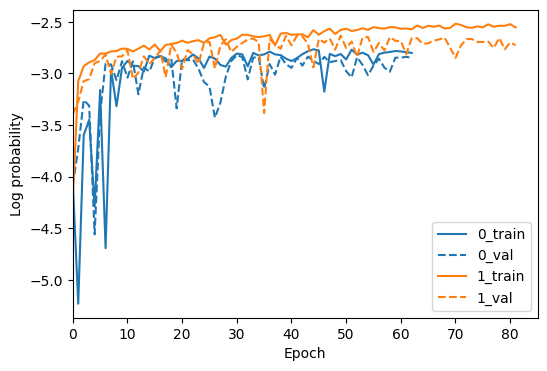

In [18]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [19]:
# Now, LampeRunner returns a custom class instance to be able to pass signature strings
# This class has simply for attributes a NeuralPosteriorEstimate and a string list 
print(posterior_ensemble.signatures)

# choose a random input
seed_in = None
np.random.seed(seed_in)
ind = np.random.randint(len(val_dataset))
x_ = val_dataset[ind][0]
y_ = val_dataset[ind][1]
dim_theta = y_.shape[-1]

# generate samples from the posterior using accept/reject sampling
seed_samp = 1234
torch.manual_seed(seed_samp)
samples = posterior_ensemble.sample((1000,), val_dataset[ind][0])



INFO:root:Sampling models with tensor([453., 547.], device='cuda:0') samples each.


['', '']


Drawing 453 posterior samples: 643it [00:00, 2551.34it/s]                         
Drawing 547 posterior samples: 996it [00:00, 2104.93it/s]                         


In [20]:
# calculate the log_prob for each sample
log_prob = posterior_ensemble.log_prob(samples, val_dataset[ind][0])

y_ = y_.cpu()#.numpy()
samples = samples.cpu().numpy()
log_prob = log_prob.cpu().numpy()

INFO:root:Sampling models with tensor([453., 547.], device='cuda:0') samples each.
Drawing 453 posterior samples: 646it [00:00, 47243.69it/s]            
Drawing 547 posterior samples: 993it [00:00, 152645.92it/s]           


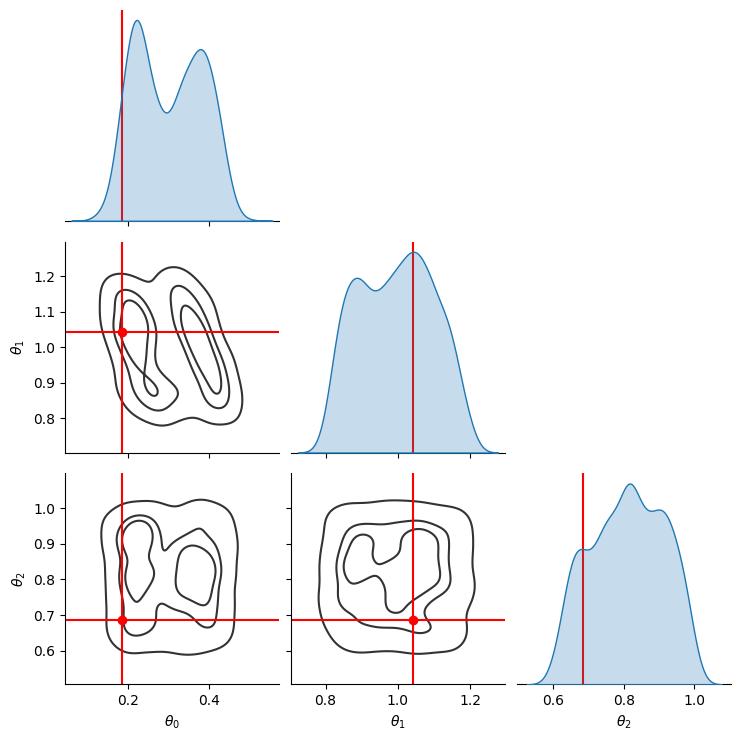

In [21]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(dim_theta)]
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = x_, theta_fid=y_
)

100%|██████████| 100/100 [00:00<00:00, 141.04it/s]


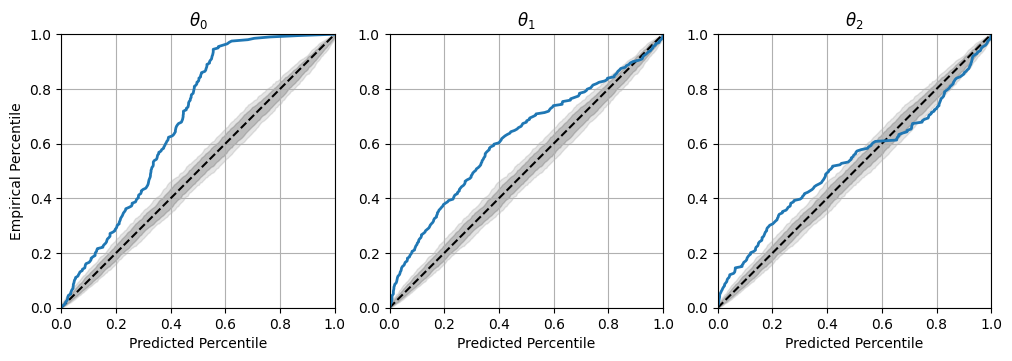

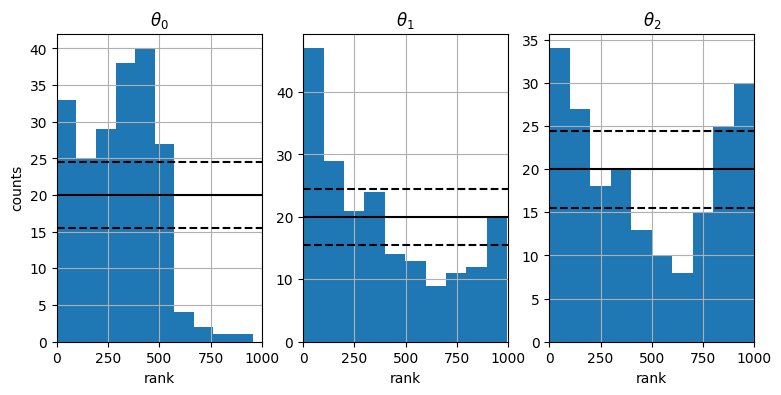

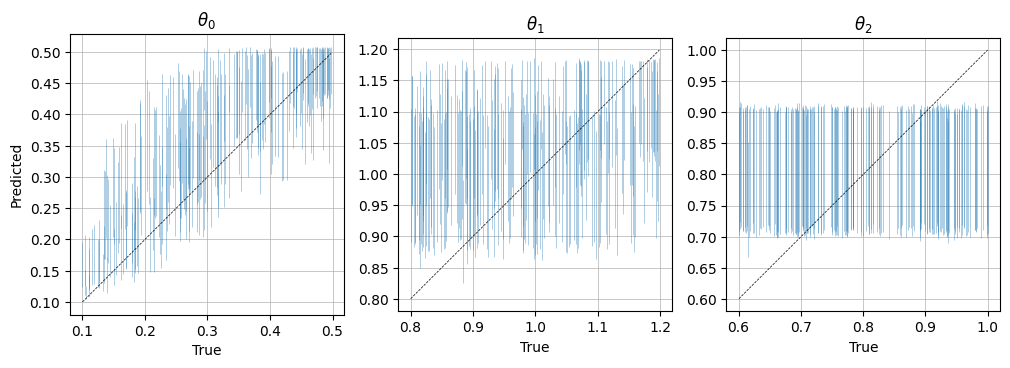

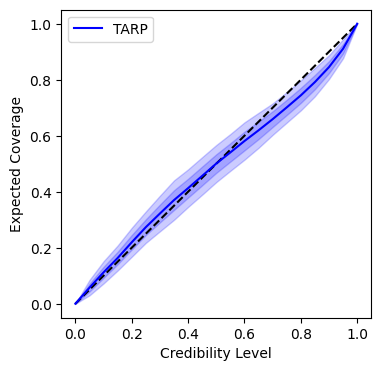

In [22]:
# Drawing samples from the ensemble posterior

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(dim_theta)],
    plot_list = ["coverage", "histogram", "predictions", "tarp"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=val_dataset.data_list, theta=val_theta,
)